# Импортирование необходимых библиотек

In [1]:
from sentinelhub import SHConfig
from sentinelhub import SentinelHubCatalog
from scipy.stats import skew, mode, kurtosis, norm
from scipy.signal import convolve2d

import datetime, os, csv, math
from datetime import timezone, timedelta
from math import ceil
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import numpy as np
from shapely.ops import unary_union
from fiona.drvsupport import supported_drivers
import geopandas as gpd
from matplotlib.path import Path
from shapely.geometry import Polygon
import earthpy.spatial as es
import earthpy.plot as ep
import numpy.ma as ma
from scipy.stats.mstats import gmean, hmean
import pandas as pd
import seaborn as sns
from functools import reduce
from itertools import tee, zip_longest

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression
from matplotlib.colors import ListedColormap

from sentinelhub import (
    CRS,
    BBox,
    DataCollection,
    DownloadRequest,
    MimeType,
    MosaickingOrder,
    SentinelHubDownloadClient,
    SentinelHubRequest,
    bbox_to_dimensions,
    filter_times
)

# The following is not a package. It is a file utils.py which should be in the same folder as this notebook.
from utils import plot_image

colors = ['tomato', 'navy', 'MediumSpringGreen', 'lightblue', 'orange', 'blue',
          'maroon', 'purple', 'yellow', 'olive', 'brown', 'cyan',
          'gold', 'teal', 'lime', 'indigo', 'coral', 'darkred',
          'darkgreen', 'magenta', 'violet', 'turquoise', 'peachpuff',
          'slateblue', 'firebrick', 'forestgreen', 'plum', 'silver', 'lavender']

import csv, json, codecs, sys
import urllib.request
import urllib.error
import pandas as pd
import pickle, random

import requests
from bs4 import BeautifulSoup

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
sns.set()

config = SHConfig()

In [3]:
catalog = SentinelHubCatalog(config=config)
# catalog.get_info()

# Получение координат экспериментального пастбища 

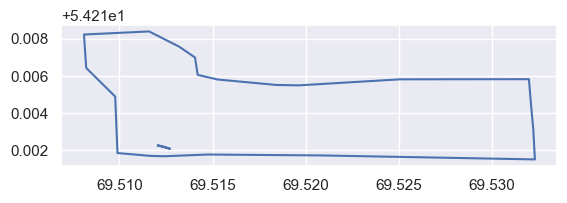

In [4]:
supported_drivers['KML'] = 'rw'
pasture_df = gpd.read_file('pasture.kml', driver='KML')

all_zagons = []
for zagon in range(len(pasture_df.index)):
    all_zagons.append(pasture_df.loc[zagon].geometry)
    
merged_zagons = unary_union(all_zagons)

gpd.GeoSeries([merged_zagons]).boundary.plot()
plt.show()

In [5]:
x_min, y_min, x_max, y_max = merged_zagons.bounds
pasture_coords_wgs84 = (x_min, y_min, x_max, y_max)

# Отправка запросов и получение снимков 

In [6]:
resolution = 10
pasture_bbox = BBox(bbox=pasture_coords_wgs84, crs=CRS.WGS84)
pasture_size = bbox_to_dimensions(pasture_bbox, resolution=resolution)

print(f"Image shape at {resolution} m resolution: {pasture_size} pixels")

Image shape at 10 m resolution: (157, 78) pixels


# Выбор одной из доступных баз данных

In [7]:
data_collection = DataCollection.SENTINEL2_L2A
bands_dict = dict([(band.name, i) for i, band in enumerate(data_collection.bands)])
aux_data_dict = dict([(band, i) for i, band in enumerate(["sunZenithAngles","sunAzimuthAngles","viewZenithMean","viewAzimuthMean"])])

universal_bands_dict = dict([(band, i) for i, band in enumerate(["AOT", "SNW", "CLD", "SCL", "CLP", "CLM", "dataMask"])])

In [8]:
year = "2022"
time_interval = f"{year}-04-01", f"{year}-09-30"

In [9]:
# LOADINGS
with open(f'results_{year}.pkl', 'rb') as f:
    results = pickle.load(f)
    
with open(f'uni_bands_data_{year}.pkl', 'rb') as f:
    uni_bands_data = pickle.load(f)
    
with open(f'all_bands_data_{year}.pkl', 'rb') as f:
    all_bands_data = pickle.load(f)

with open(f'aux_data_{year}.pkl', 'rb') as f:
    aux_data = pickle.load(f)
    
with open(f'unique_acquisitions_{year}.pkl', 'rb') as f:
    unique_acquisitions = pickle.load(f)         

# Составление маски пастбища

In [10]:
 aoi_height, aoi_width, _ = all_bands_data[-1].shape

In [11]:
masks = []
pasture_edges = []
for zagon in range(len(pasture_df)-1):
    polygon=[]

    for coords in pasture_df.loc[zagon].geometry.exterior.coords:

        x = int(np.interp(coords[0], [x_min, x_max], [0, aoi_width]))
        y = int(np.interp(coords[1], [y_min, y_max], [aoi_height, 0]))

        polygon.append((y, x))
        
    poly_path=Path(polygon)
    x, y = np.mgrid[:aoi_height, :aoi_width]
    coors=np.hstack((x.reshape(-1, 1), y.reshape(-1,1)))
    
    pasture_edges.append(Polygon(polygon))
    
    mask = ~poly_path.contains_points(coors)
    masks.append(mask)
    
combined_mask = reduce(np.logical_and, masks)

# Маска для загона №1 

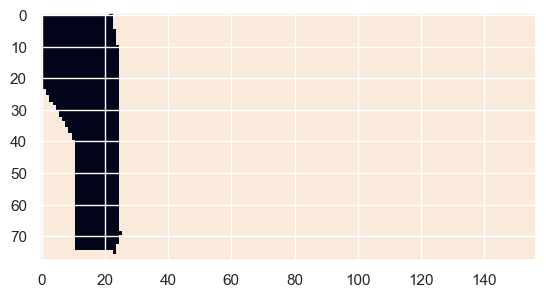

In [12]:
plt.imshow(masks[0].reshape(aoi_height, aoi_width))
plt.show()

# Маска для пастбища

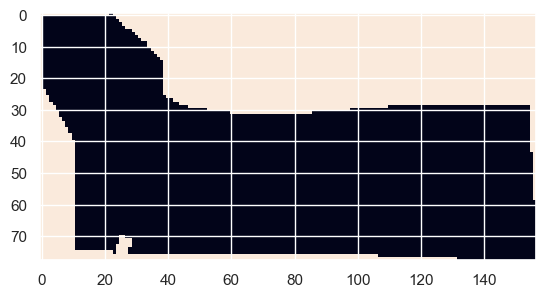

In [13]:
plt.imshow(combined_mask.reshape(aoi_height, aoi_width))
plt.show()

# Объявление вспомогательных функции

In [78]:
weights = {
    'temperature_2m_max': 1,
    'temperature_2m_min': 1,
    'apparent_temperature_max': 1,
    'apparent_temperature_min': 1,
    'precipitation_sum': 1,
    'rain_sum': 1,
    'snowfall_sum': 1,
    'precipitation_hours': 1,
    'windspeed_10m_max': 1,
    'winddirection_10m_dominant': 1,
    'shortwave_radiation_sum': 1,
    'et0_fao_evapotranspiration': 1,
    'sunZenithAngles': 0,
    'sunAzimuthAngles': 0,
    'viewZenithMean': 0,
    'viewAzimuthMean': 0,
}

def normalize(band):
    band_min, band_max = (band.min(), band.max())
    return ((band - band_min)/((band_max - band_min)))

def brighten(band):
    alpha=0.13
    beta=0
    return np.clip(alpha*band+beta, 0, 255)

def Kcluster(matrix, n_clusters=3):
#     scaler = MinMaxScaler(); matrix = scaler.fit_transform(matrix);
#     scaler = StandardScaler(); matrix = scaler.fit_transform(matrix);

    flattened_matrix = matrix.flatten()

    kmeans = KMeans(n_clusters=n_clusters, random_state=45)
    kmeans.fit(flattened_matrix.reshape(-1, 1))

    cluster_labels = kmeans.labels_
    result_index = cluster_labels.reshape(matrix.shape)
    result_index = ma.masked_array(result_index, mask=combined_mask.reshape(aoi_height, aoi_width))

    return ~(result_index == 0), ~(result_index == 1), ~(result_index == 2) 

def get_only_pasture(index):
    only_pasture = ma.masked_array(ma.masked_array((index), mask=np.isinf((index)) | np.isnan((index))), mask=combined_mask.reshape(aoi_height, aoi_width))
    return only_pasture

def get_only_zagon(index, zagon):
    only_zagon = ma.masked_array(ma.masked_array((index), mask=np.isinf((index)) | np.isnan((index))), mask=masks[zagon-1].reshape(aoi_height, aoi_width))
    return only_zagon

def change_difference(days_diff, zagon):
    if zagon > 0:
        return get_only_zagon(days_diff, zagon)
    else:
        return days_diff

def mean(index):
    return float(index.mean())

def median(index):
    return float(ma.median(index))

def get_date_slice(data, start_date, end_date):
    start_dt = datetime.datetime.strptime(start_date, '%Y-%m-%d')
    end_dt = datetime.datetime.strptime(end_date, '%Y-%m-%d')
    result = {
        key: value
        for key, value in data.items()
        if start_dt <= datetime.datetime.strptime(key, '%Y-%m-%d') <= end_dt
    }
    return result

def pairwise(iterable):
    a, b = tee(iterable)
    next(b, None)
    return zip_longest(a, b)

def show_real_pasture():
    fig, ax = plt.subplots(figsize=(12, 6))
    for zagon in range(len(pasture_df)-1):
        ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])
    ep.plot_rgb(np.stack([RED, GREEN, BLUE]), ax=ax, title=general_info, figsize=(12, 6))
    plt.show()    


def scale_to_unit_range_np(values):
    values = np.array(values)  # Convert the list to a NumPy array
    old_min, old_max = values.min(), values.max()  # Get the min and max values
    scaled_values = (values - old_min) / (old_max - old_min)  # Apply scaling formula
    return scaled_values


def show_hist_and_scatter(zagon, all_pasture_OR_each_paddock, paddock_id, header):
    i = paddock_id
    
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))  # Create side-by-side subplots

    # Histogram plot (left subplot)
    ax_hist = axs[0]
    n, bins, patches = ax_hist.hist(
        zagon.compressed(),  # Use .compressed() to handle masked arrays
        bins=30,
        color=colors[i],
        alpha=0.5,
        edgecolor='black',
        label="Histogram"
    )

    # Calculate statistics
    mean = zagon.mean()
    median = ma.median(zagon)
    std_dev = zagon.std()
    flattened_matrix = zagon.compressed()
    skewness_value = skew(flattened_matrix)
    Q1 = np.percentile(flattened_matrix, 25)
    Q3 = np.percentile(flattened_matrix, 75)
    IQR = Q3 - Q1
    kurtosis_value = kurtosis(flattened_matrix)

    # Add vertical lines
    ax_hist.axvline(zagon.max(), color='r', linestyle=':', linewidth=2, label=f"Max: {zagon.max()}")
    ax_hist.axvline(zagon.min(), color='b', linestyle=':', linewidth=2, label=f"Min: {zagon.min()}")
    ax_hist.axvline(mean, color='b', linestyle='dashed', linewidth=2, label=f"Arithmetic mean: {mean}")
    ax_hist.axvline(median, color='r', linestyle='dashed', linewidth=2, label=f"Median: {median}")

    # Mask negative or zero values for harmonic and geometric means
    if not (zagon <= 0).sum():
        harmonic_mean = hmean(flattened_matrix)
        geometric_mean = gmean(flattened_matrix)
        ax_hist.axvline(harmonic_mean, color='g', linestyle='dashed', linewidth=2, label=f"Harmonic mean: {harmonic_mean}")
        ax_hist.axvline(geometric_mean, color='y', linestyle='dashed', linewidth=2, label=f"Geometric mean: {geometric_mean}")

    # Bell curve
    x = np.linspace(bins[0], bins[-1], 500)
    bell_curve = norm.pdf(x, loc=mean, scale=std_dev)
    bell_curve_scaled = bell_curve * n.max() / bell_curve.max()
    ax_hist.plot(x, bell_curve_scaled, color='m', linewidth=2, label="Normal distribution")

    # Annotate histogram with additional statistics
    ax_hist.axvline(mean, color='white', linestyle='--', label=f'Standard deviation: {std_dev}', alpha=0)
    ax_hist.axvline(mean, color='white', linestyle='--', label=f'Skewness: {skewness_value}', alpha=0)
    ax_hist.axvline(mean, color='white', linestyle='--', label=f'Interquartile range (IQR): {IQR}', alpha=0)
    ax_hist.axvline(mean, color='white', linestyle='--', label=f'Kurtosis (Excess kurtosis): {kurtosis_value}', alpha=0)

    # Finalize histogram
    ax_hist.legend(title=f'Sum: {round(zagon.sum(), precision)}')
    
    if all_pasture_OR_each_paddock:
        ax_hist.set_title(f'{header} || Pasture {general_info}')
    else:
        ax_hist.set_title(f'{header} || Paddock-{i+1} {general_info}')
        
    ax_hist.set_xlabel('Value')
    ax_hist.set_ylabel('Frequency')

    # Scatter plot (right subplot)
    ax_scatter = axs[1]
    x = np.arange(zagon.size)
    y = zagon.flatten()
    unmasked_values = zagon.compressed()

    mean_value = np.ma.mean(zagon)
    median_value = np.ma.median(zagon)
    if not (zagon <= 0).sum():
        geometric_mean = gmean(unmasked_values)
        harmonic_mean = hmean(unmasked_values)

    ax_scatter.scatter(x, y, s=100, label="Values", color=colors[i])
    ax_scatter.axhline(y=mean_value, color='b', linestyle='--', label=f'Arithmetic mean: {mean_value}')
    ax_scatter.axhline(y=median_value, color='r', linestyle='--', label=f'Median: {median_value}')
    if not (zagon <= 0).sum():
        ax_scatter.axhline(y=geometric_mean, color='y', linestyle='--', label=f'Geometric mean: {geometric_mean}')
        ax_scatter.axhline(y=harmonic_mean, color='g', linestyle='--', label=f'Harmonic mean: {harmonic_mean}')

    if all_pasture_OR_each_paddock:
        ax_scatter.set_title(f'{header} || Pasture {general_info}')
    else:
        ax_scatter.set_title(f'{header} || Paddock-{i+1} {general_info}')
        
    ax_scatter.set_xlabel('Index')
    ax_scatter.set_ylabel('Value')
    ax_scatter.legend()

    plt.tight_layout()
    plt.show()    

    
summary_df = None
def show_pasture_index(test_meet, lower_bound, upper_bound, show_hists=True, save_excel=False, show_index=True, show_table=True):
    global summary_df
    precision = 4
    header = None
    
    if show_index:
        fig, ax = plt.subplots(figsize=(12, 12))
        for zagon in range(len(pasture_df)-1):

            ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

        header = input_text
        # print(f"Max: {round(float(test_meet.max()),precision)} || Min: {round(float(test_meet.min()),precision)} || Arithmetic mean: {round(float(test_meet.mean()),precision)} || Sum: {round(float(test_meet.sum()),precision)}")
        ep.plot_bands(test_meet, title=f"{header} {general_info}", ax=ax, cmap="seismic", cols=1, vmin=lower_bound, vmax=upper_bound, figsize=(10, 14))
        plt.show()

    test_index_masked_array = []
    for i, mask in enumerate(masks):
        mx = ma.masked_array(test_meet, mask=mask.reshape(aoi_height, aoi_width))
        test_index_masked_array.append(mx)


    weather_parameters = history_df[history_df["time"]==date_chosen]

    weather_parameters = weather_parameters.assign(
        sunZenithAngles=SZA,
        sunAzimuthAngles=SAA,
        viewZenithMean=VZM,
        viewAzimuthMean=VAM)
    
#     weather_parameters = weather_parameters.drop(columns=["time"], inplace=False)
#     weighted_vector = (weather_parameters * pd.Series(weights)).sum(axis=1)
#     print(weighted_vector)
          
#     NWC = (float(weighted_vector.iloc[0]) - 393.2550463180542) / (590.1110732021332 - 393.2550463180542)
    
    summary_data = []
    for i, zagon in enumerate(test_index_masked_array):
#         resource = round(8.59 * ma.median(zagon) + 0.20 * NWC + -7.04, precision) 

        geometric_mean = round(float(gmean(zagon.reshape(aoi_width * aoi_height))),precision)
        harmonic_mean = round(float(hmean(zagon.reshape(aoi_width * aoi_height))),precision)
        
        std_dev = zagon.std()
        flattened_matrix = zagon.compressed()
        skewness_value = skew(flattened_matrix)
        Q1 = np.percentile(flattened_matrix, 25); Q3 = np.percentile(flattened_matrix, 75)
        IQR = Q3 - Q1
        kurtosis_value = kurtosis(flattened_matrix)

        temp_resource = 8.87 * ma.median(zagon) + 0.03 * alter_weather_param_df["temp"].iloc[0] -7.91 # (Temperature)
        press_resource = 9.12 * ma.median(zagon) -0.01 * alter_weather_param_df["pressure"].iloc[0] + 2.18 # (Pressure)
        humid_resource = 8.49 * ma.median(zagon) -0.00 * alter_weather_param_df["humidity"].iloc[0] -6.66 # (Moisture)
        angle_resource = 8.95 * ma.median(zagon) -0.03 * (SZA + VZM) -6.06 # (SZA + VZM = RZA)

        resource = round(np.array([temp_resource, press_resource, humid_resource, angle_resource]).mean(), precision)
                
        summary_data.append([f"№{i+1}", round(zagon.sum(),precision), round(zagon.mean(),precision), round(ma.median(zagon),precision), geometric_mean, harmonic_mean, round(std_dev,precision), round(skewness_value,precision), round(IQR,precision), round(kurtosis_value,precision), round(zagon.max(),precision), round(zagon.min(),precision), round(ma.count(zagon)*(10**2)*0.0001,precision), resource])


    styles = [
        {'selector': '',
         'props': [('border', '2px solid #000'), ('border-collapse', 'collapse')]},
        {'selector': 'th',
         'props': [('border', '2px solid #000')]},
        {'selector': 'td',
         'props': [('border', '1px solid #000'), ('padding', '5px')]}
    ]

    summary_df = pd.DataFrame(data = summary_data, columns=["Paddock", "Sum", "Arithmetic mean", "Median", 'Geometric mean', 'Harmonic mean', "Standard deviation", "Skewness", "Interquartile range (IQR)", "Kurtosis (Excess kurtosis)", "Max", "Min", "Area (ha)", "Resource (t/ha)"])

    std_dev = test_meet.std()
    flattened_matrix = test_meet.compressed()
    skewness_value = skew(flattened_matrix)
    Q1 = np.percentile(flattened_matrix, 25); Q3 = np.percentile(flattened_matrix, 75)
    IQR = Q3 - Q1
    kurtosis_value = kurtosis(flattened_matrix)

    sum_row = pd.DataFrame({'Paddock': ["Pasture"], 
                            'Sum': [round(float(summary_df['Sum'].sum()),precision)], 
                            'Arithmetic mean': [round(float(test_meet.mean()),precision)], 
                            'Median': [round(float(ma.median(test_meet)),precision)], 
                            
                            'Geometric mean': [round(float(gmean(test_meet.reshape(aoi_width * aoi_height))),precision)], 
                            'Harmonic mean': [round(float(hmean(test_meet.reshape(aoi_width * aoi_height))),precision)], 

                            'Standard deviation': [round(float(std_dev),precision)],
                            'Skewness': [round(float(skewness_value),precision)],
                            'Interquartile range (IQR)': [round(float(IQR),precision)],
                            'Kurtosis (Excess kurtosis)': [round(float(kurtosis_value),precision)],
                            
                            'Max': [round(float(summary_df['Max'].max()),precision)], 
                            'Min': [round(float(summary_df['Min'].min()),precision)], 
                            'Area (ha)': [summary_df['Area (ha)'].sum()], 
                            'Resource (t/ha)': [summary_df['Resource (t/ha)'].sum()]}, index=[len(summary_df.index)])

    summary_df = pd.concat([summary_df, sum_row])
    summary_df = summary_df.round(precision)
    
    if save_excel:
        summary_df.to_excel(f"Summary_{date_chosen}_{data_collection.processing_level}.xlsx", index=None)
    styled_df = summary_df.style.set_table_styles(styles)
    styled_df.hide(axis="index")
    
    if show_table:
        display(styled_df)
    
    if show_hists: 
        show_hist_and_scatter(test_meet, True, 27, header)
        # Loop through each dataset in test_index_masked_array
#         for i, zagon in enumerate(test_index_masked_array):
#             show_hist_and_scatter(zagon, False, i, header)
        
        
def get_all_bands(by_pasture=False):
    global ULTRA_BLUE, BLUE, GREEN, RED, RED_EDGE1, RED_EDGE2, RED_EDGE3, NIR, N_NIR, WV, SWIR_C, SWIR2, SWIR3, SAA, SZA, VAM, VZM
    
    if by_pasture:
        # Нормализированные по пастбищу
        ULTRA_BLUE = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B01"]])))

        BLUE = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B02"]])))
        GREEN = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B03"]])))
        RED = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B04"]])))

        RED_EDGE1 = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B05"]])))
        RED_EDGE2 = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B06"]])))
        RED_EDGE3 = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B07"]])))

        NIR = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B08"]])))
        N_NIR = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B8A"]])))
        WV = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B09"]])))
        if "B10" in bands_dict:
            SWIR_C = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B10"]])))
        SWIR2 = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B11"]])))
        SWIR3 = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B12"]])))
    else:
        # НЕ Нормализированные по пастбищу
        ULTRA_BLUE = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B01"]])))

        BLUE = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B02"]])))
        GREEN = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B03"]])))
        RED = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B04"]])))

        RED_EDGE1 = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B05"]])))
        RED_EDGE2 = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B06"]])))
        RED_EDGE3 = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B07"]])))

        NIR = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B08"]])))
        N_NIR = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B8A"]])))
        WV = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B09"]])))
        if "B10" in bands_dict:
            SWIR_C = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B10"]])))
        SWIR2 = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B11"]])))
        SWIR3 = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B12"]])))

    SAA = (aux_data[image_date][:, :, aux_data_dict["sunAzimuthAngles"]]).mean()
    SZA = (aux_data[image_date][:, :, aux_data_dict["sunZenithAngles"]]).mean()
    VAM = (aux_data[image_date][:, :, aux_data_dict["viewAzimuthMean"]]).mean()
    VZM = (aux_data[image_date][:, :, aux_data_dict["viewZenithMean"]]).mean()

# Выбор порога облачности

In [15]:
# cloud_brightness_percent = 40 # %
# cloud_coverage_percent = 1 # %

# white_noise_threshold = int(np.interp(cloud_brightness_percent, [0, 100], [0, 255]))
# white_noise_count = int(np.interp(cloud_coverage_percent, [0, 100], [0, (aoi_height*aoi_width)]))

white_noise_threshold = 255 # 50
white_noise_count = 12246 # 300 / 12246

In [16]:
image_date_cloud = []
for date in unique_acquisitions:
    for index in range(len(results)):
        if datetime.datetime.strptime(results[index]['properties']['datetime'], "%Y-%m-%dT%H:%M:%SZ").replace(tzinfo=timezone.utc) == date:
            image_date_cloud.append((str(date.date()), results[index]['properties']["eo:cloud_cover"]))
image_date_cloud = dict(image_date_cloud)

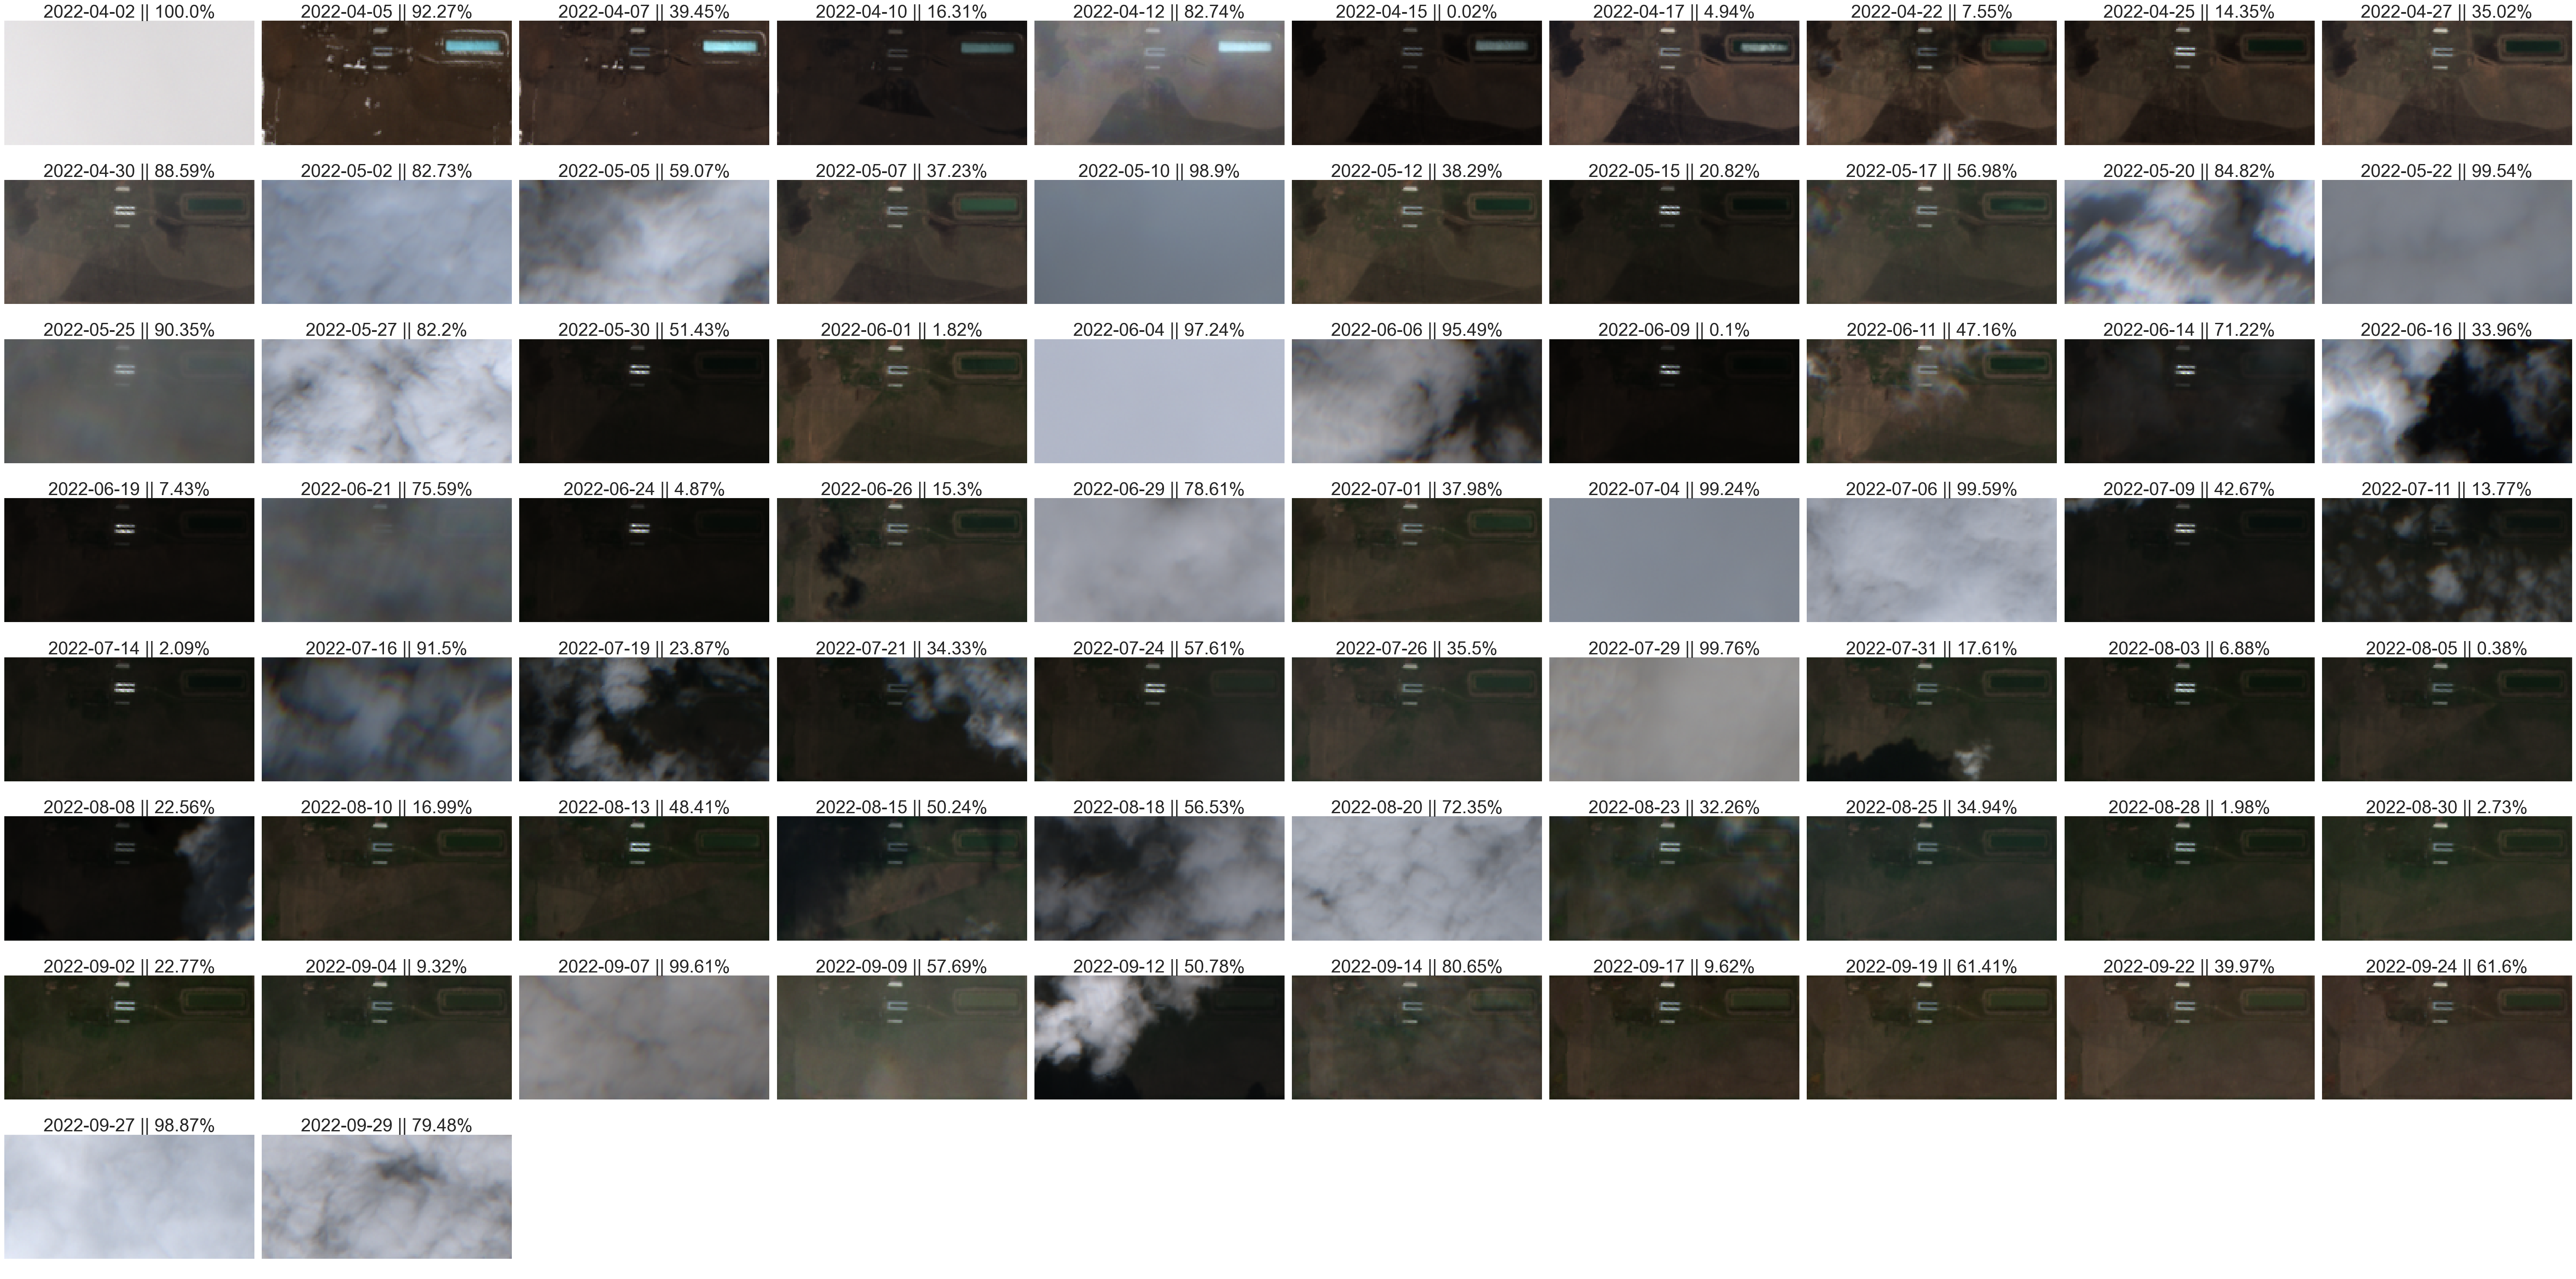

In [17]:
cols = 10
ncols, nrows = cols, ceil(len(results)/cols) 

fig, axis = plt.subplots(
    ncols=ncols, nrows=nrows, figsize=(60, 30), subplot_kw={"xticks": [], "yticks": [], "frame_on": False}
)

idx = 0
clear_date_dict = []
for i, (image, timestamp) in enumerate(zip(all_bands_data, unique_acquisitions)):

    data = image.astype(np.float64) / image.max()
    data = 255 * data
    image = data.astype(np.uint8)
    
    mx1 = ma.masked_array(image[:,:,bands_dict["B02"]], mask=combined_mask.reshape(aoi_height, aoi_width))
    mx2 = ma.masked_array(image[:,:,bands_dict["B03"]], mask=combined_mask.reshape(aoi_height, aoi_width))
    mx3 = ma.masked_array(image[:,:,bands_dict["B04"]], mask=combined_mask.reshape(aoi_height, aoi_width))
    comb = mx1&mx2&mx3
    white_image = comb >= white_noise_threshold
    if white_image.sum() <= white_noise_count:
        clear_date_dict.append((str(timestamp.date().isoformat()), i))
        ax = axis[idx // ncols][idx % ncols]
        image = np.stack([image[:,:,bands_dict["B04"]], image[:,:,bands_dict["B03"]], image[:,:,bands_dict["B02"]]])
        ax.imshow(np.transpose(image, (1, 2, 0)))
        ax.set_title(timestamp.date().isoformat()+ ' || ' + str(image_date_cloud[timestamp.date().isoformat()]) + "%", fontsize=30)
        idx += 1
        
clear_date_dict = dict(clear_date_dict)
plt.tight_layout()

# Анализ погодных параметров и каналов

## Координаты пастбища

In [18]:
longitude = pasture_bbox.geometry.centroid.coords.xy[0][0]
latitude = pasture_bbox.geometry.centroid.coords.xy[1][0]

In [19]:
forecast_parameters = [
"temperature_2m_max",
"temperature_2m_min",
"apparent_temperature_max",
"apparent_temperature_min",
"precipitation_sum",
"rain_sum",
"showers_sum",
"snowfall_sum",
"precipitation_hours",
"precipitation_probability_max",
"precipitation_probability_min",
"precipitation_probability_mean",
"weathercode",
"sunrise",
"sunset",
"windspeed_10m_max",
"windgusts_10m_max",
"winddirection_10m_dominant",
"shortwave_radiation_sum",
"et0_fao_evapotranspiration",
"uv_index_max",
"uv_index_clear_sky_max",]

history_parameters = [
"temperature_2m_max",
"temperature_2m_min",
"apparent_temperature_max",
"apparent_temperature_min",
"precipitation_sum",
"rain_sum",
"snowfall_sum",
"precipitation_hours",
"weathercode",
"sunrise",
"sunset",
"windspeed_10m_max",
"windgusts_10m_max",
"winddirection_10m_dominant",
"shortwave_radiation_sum",
"et0_fao_evapotranspiration",]


last_main_description = ""

def get_weather_mapping():
    global last_main_description
    
    url = "https://www.nodc.noaa.gov/archive/arc0021/0002199/1.1/data/0-data/HTML/WMO-CODE/WMO4677.HTM"
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')

    weather_mapping = {}
    
    for i_table, table in enumerate(soup.select('table[BORDER]')):
        for i_row, row in enumerate(table.find_all('tr')[1:]):
            code_and_description = row.find_all('td')[:2]
            code = int(code_and_description[0].text.strip())
            description = code_and_description[1].text.strip()
            if not description.startswith("-"):
                last_main_description = description
            else:
                description = last_main_description
            weather_mapping[code] = description
            
            
    return weather_mapping

def weather_code_to_string(wmo_code):
    return weather_mapping.get(wmo_code, "Unknown Weather Code")

# Generate the weather mapping
weather_mapping = get_weather_mapping()


def apply_params_to_URL(URL, parameters):
    URL += "&daily="
    for i, parameter in enumerate(parameters):
        if i < len(parameters) - 1:
            URL += parameter + ","
        else:
            URL += parameter
    URL += "&timezone=auto"
    
    print("URL updated: ", URL)
    return URL

def make_API_request(URL):
    try:
        # Convert from bytes to text
        resp_text = urllib.request.urlopen(URL).read().decode('UTF-8')
        # Use loads to decode from text
        json_obj = json.loads(resp_text)
        print("Successfull API request!")
        return json_obj
    except urllib.error.HTTPError  as e:
        ErrorInfo= e.read().decode()
        print('Error code: ', e.code, ErrorInfo)
        sys.exit()
    except  urllib.error.URLError as e:
        ErrorInfo= e.read().decode()
        print('Error code: ', e.code,ErrorInfo)
        sys.exit()

# История погоды по заданному диапазону

In [20]:
start_date = time_interval[0]
end_date = time_interval[-1]

In [21]:
Hist_URL = f"https://archive-api.open-meteo.com/v1/archive?latitude={latitude}&longitude={longitude}&start_date={start_date}&end_date={end_date}"

In [22]:
Hist_URL = apply_params_to_URL(Hist_URL, history_parameters)

URL updated:  https://archive-api.open-meteo.com/v1/archive?latitude=54.21495200000001&longitude=69.52020049999999&start_date=2022-04-01&end_date=2022-09-30&daily=temperature_2m_max,temperature_2m_min,apparent_temperature_max,apparent_temperature_min,precipitation_sum,rain_sum,snowfall_sum,precipitation_hours,weathercode,sunrise,sunset,windspeed_10m_max,windgusts_10m_max,winddirection_10m_dominant,shortwave_radiation_sum,et0_fao_evapotranspiration&timezone=auto


In [23]:
history_json_obj = make_API_request(Hist_URL)

Successfull API request!


In [24]:
history_df = pd.DataFrame(history_json_obj["daily"])
history_df.drop(columns=["weathercode", "sunrise", "sunset"], inplace=True)

In [25]:
history_df

,time,temperature_2m_max,temperature_2m_min,apparent_temperature_max,apparent_temperature_min,precipitation_sum,rain_sum,snowfall_sum,precipitation_hours,windspeed_10m_max,windgusts_10m_max,winddirection_10m_dominant,shortwave_radiation_sum,et0_fao_evapotranspiration
0,2022-04-01,8.9,0.1,5.4,-3.9,0.0,0.0,0.00,0.0,22.1,38.5,229,15.37,1.90
1,2022-04-02,7.1,1.4,4.0,-2.2,1.4,1.4,0.00,7.0,22.2,38.9,232,6.75,0.93
2,2022-04-03,14.9,2.5,12.1,-1.7,1.1,1.1,0.00,3.0,18.9,32.0,230,16.92,2.35
3,2022-04-04,19.3,4.6,14.7,0.7,0.0,0.0,0.00,0.0,20.5,38.9,193,16.17,3.46
4,2022-04-05,15.4,5.7,10.9,0.4,0.0,0.0,0.00,0.0,26.9,51.5,219,17.40,3.38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178,2022-09-26,9.6,5.2,6.3,1.4,11.6,11.6,0.00,18.0,24.5,45.0,80,1.62,0.36
179,2022-09-27,6.5,0.8,3.2,-4.4,6.4,5.8,0.42,19.0,19.5,36.4,355,2.42,0.57
180,2022-09-28,2.9,-2.8,-2.7,-7.2,1.3,0.0,0.91,8.0,18.5,36.7,325,9.85,1.17
181,2022-09-29,1.9,-4.8,-2.7,-8.7,0.1,0.0,0.07,1.0,12.7,26.6,314,8.30,0.97


In [26]:
def get_main_weather_params_history(seek_date):
    if isinstance(seek_date, list):
        l = []
        for d in seek_date:
            l.append(round_up_to_hour(d))
        date_list_df = pd.DataFrame({'dt_iso': l})
        df = pd.merge(grand_history_weather_df, date_list_df, on='dt_iso', how='right')
        df = df.drop(columns=['dt', 'dt_iso', 'timezone', 'city_name', 'lat', 'lon', 'weather_id', 'weather_main', 'weather_description', 'weather_icon'])
    else:
        df = grand_history_weather_df[grand_history_weather_df["dt_iso"] == round_up_to_hour(seek_date)]
        df = df.drop(columns=['dt', 'dt_iso', 'timezone', 'city_name', 'lat', 'lon', 'weather_id', 'weather_main', 'weather_description', 'weather_icon'])
    return df.reset_index(drop=True)

def round_up_to_hour(timestamp):
    if timestamp.minute >= 30:
        # If minutes are above 30, round up to the next hour
        rounded_timestamp = timestamp.replace(
            minute=0, second=0, microsecond=0
        ) + timedelta(hours=1)
    else:
        # Otherwise, round down to the current hour
        rounded_timestamp = timestamp.replace(minute=0, second=0, microsecond=0)

    return rounded_timestamp.strftime('%Y-%m-%d %H:%M:%S %z %Z')

grand_history_weather_df = pd.read_csv('Pasture_Weather_History.csv')

In [27]:
image_date_cloud = []
for date in unique_acquisitions:
    for index in range(len(results)):
        if datetime.datetime.strptime(results[index]['properties']['datetime'], "%Y-%m-%dT%H:%M:%SZ").replace(tzinfo=timezone.utc) == date:
            image_date_cloud.append((str(date.date()), results[index]['properties']["eo:cloud_cover"]))
image_date_cloud = dict(image_date_cloud)

# Дифференциальный анализ по дням

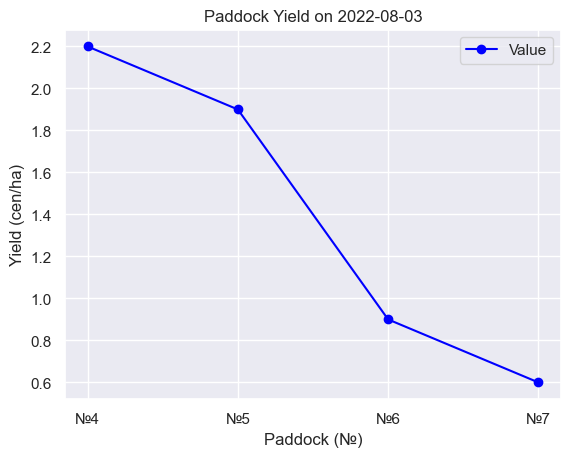

In [100]:
x = ["№4", "№5", "№6", "№7"]
y = [2.2, 1.9, 0.9, 0.6]
correlation_dict = dict()

# Plot with markers
plt.plot(x, y, marker='o', color='blue', label='Value')

# Customize axes and title
plt.xlabel('Paddock (№)')
plt.ylabel('Yield (cen/ha)')
plt.title(f'Paddock Yield on {start_date}')

# Add a legend
plt.legend()

# Show the plot
plt.show()

In [29]:
desired_median = 0.91206

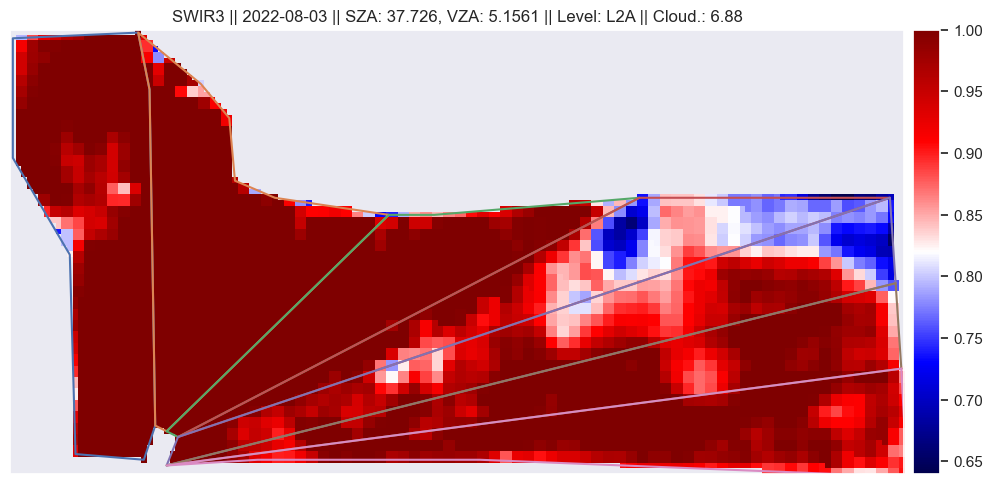

Paddock,Sum,Arithmetic mean,Median,Geometric mean,Harmonic mean,Standard deviation,Skewness,Interquartile range (IQR),Kurtosis (Excess kurtosis),Max,Min,Area (ha),Resource (t/ha)
№1,1315.086800,0.986600,1.000000,0.986000,0.985300,0.032700,-3.457800,0.004100,13.863700,1.000000,0.738500,13.330000,1.548400
№2,1239.928600,0.991900,1.000000,0.991300,0.990600,0.032900,-5.091000,0.000000,28.560200,1.000000,0.731900,12.500000,1.548400
№3,848.201500,0.990900,1.000000,0.990300,0.989500,0.033400,-4.778800,0.000000,24.640200,1.000000,0.735200,8.560000,1.548400
№4,827.152800,0.872500,0.859800,0.867300,0.862000,0.094700,-0.110000,0.168400,-0.966200,1.000000,0.639800,9.480000,0.306500
№5,1152.511700,0.911800,0.935500,0.908000,0.904000,0.080300,-0.971700,0.114700,0.078100,1.000000,0.651800,12.640000,0.977100
№6,966.567900,0.973400,0.997500,0.972500,0.971500,0.040600,-1.989900,0.041400,4.379600,1.000000,0.759400,9.930000,1.526300
№7,1086.568500,0.973600,0.993700,0.972900,0.972200,0.036600,-1.432900,0.041400,1.209700,1.000000,0.829100,11.160000,1.492300
Pasture,7436.017600,0.958300,1.000000,0.955500,0.952500,0.069100,-1.913600,0.058500,3.093300,1.000000,0.639800,77.600000,8.947400


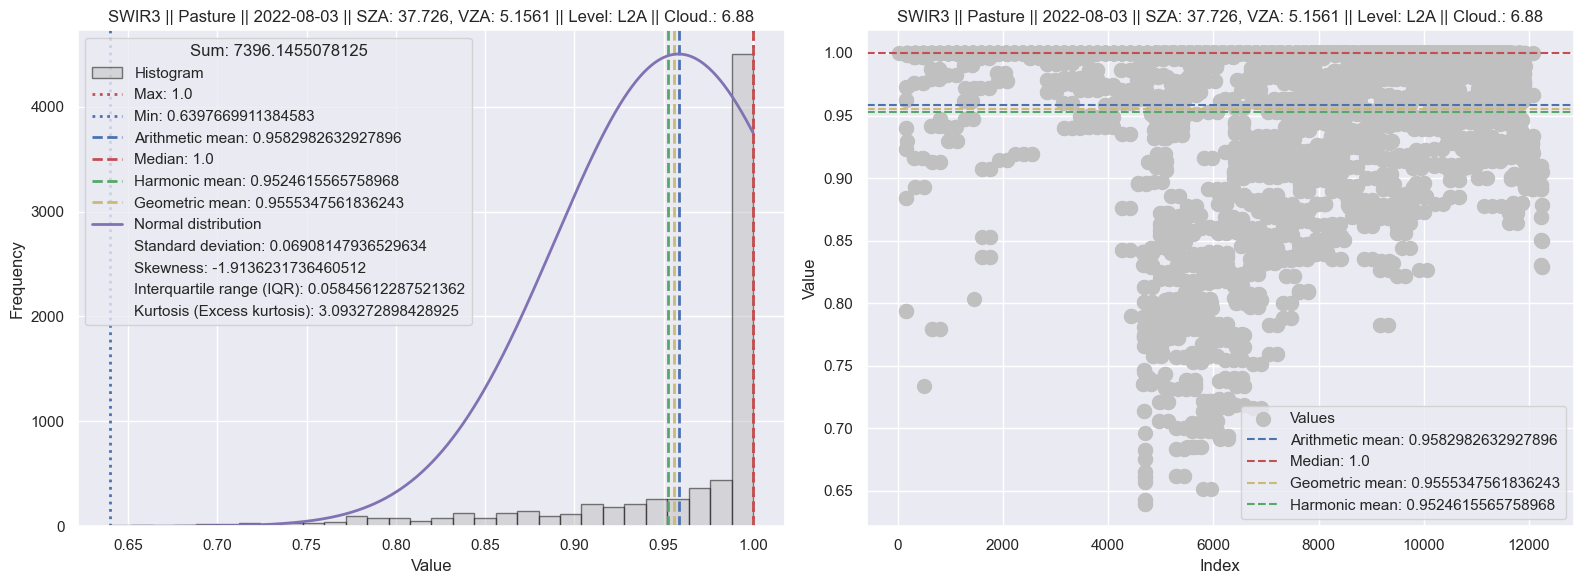

In [96]:
start_date = f'{year}-08-03'
end_date = f'{year}-08-03'

indices_dict = dict()
weather_cond_dict = {
    "pressure": [],
    "humidity": [],
    "temperature": [],
}
angles = {
    "SZA": [],
    "SAA": [],
    "VZM": [],
    "VAM": [],            
}

result_slice = get_date_slice(clear_date_dict, start_date, end_date)

for date_chosen in result_slice.keys():

    dt_object = datetime.datetime.strptime(date_chosen, "%Y-%m-%d")
    desired_time = datetime.timedelta(hours=6)
    desired_timezone = datetime.timezone.utc
    result_datetime = dt_object.replace(hour=7, minute=0, second=0, tzinfo=desired_timezone)
    alter_weather_param_df = get_main_weather_params_history(result_datetime)
    
    weather_cond_dict["temperature"].append(alter_weather_param_df["temp"].iloc[0])
    weather_cond_dict["pressure"].append(alter_weather_param_df["pressure"].iloc[0])
    weather_cond_dict["humidity"].append(alter_weather_param_df["humidity"].iloc[0])
    
    image_date = clear_date_dict[date_chosen]
    get_all_bands(by_pasture=False)
    precision = 4
    general_info = f"|| {date_chosen} || SZA: {str(round(SZA, precision))}, VZA: {str(round(VZM, precision))} || Level: {data_collection.processing_level} || Cloud.: {image_date_cloud[date_chosen]}"
    
    input_text = "SWIR3"
#     input_text = "(NIR-RED)/(NIR+RED)" # NDVI
#     input_text = "(BLUE+NIR)/(RED+SWIR3)" # Our New Formula
    
    test_index = eval(input_text)
    
    test_thresh = test_index.min() 
#     test_thresh = (test_index.max() + test_index.min())/2
    
    test_filter = test_index >= test_thresh; test_mask = ~test_filter
    test_meet = ma.masked_array(test_index, mask=test_mask)
        
#     lower_bound = 0;  upper_bound = 1
    lower_bound = test_meet.min(); upper_bound = test_meet.max()
    
    
#     current_median = ma.median(test_meet)
#     coefficient = desired_median / current_median
#     test_meet = test_meet * coefficient    
    
    
#     show_real_pasture()
    show_pasture_index(test_meet, lower_bound, upper_bound, show_hists=True, save_excel=False, show_index=True, show_table=True)
    
    indices_dict[date_chosen] = test_meet

    angles["SZA"].append(SZA);
    angles["SAA"].append(SAA);
    angles["VZM"].append(VZM);
    angles["VAM"].append(VAM);    

In [97]:
# plt.bar(summary_df["Загон"], summary_df["Межкв. размах"])

C:\Users\Пользователь\AppData\Roaming\Python\Python39\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\Пользователь\AppData\Roaming\Python\Python39\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


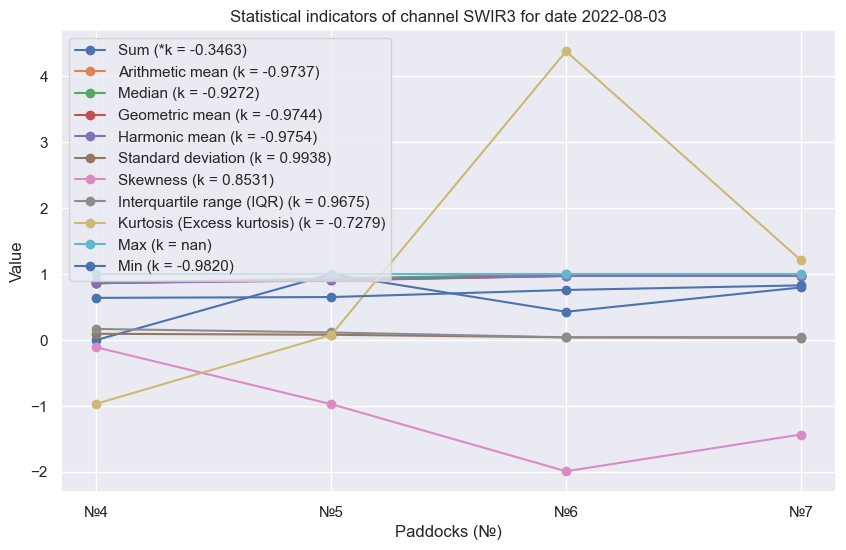

In [98]:
filtered_df = summary_df[summary_df['Paddock'].isin(["№4", "№5", "№6", "№7"])]
    
# Select a range of columns to plot (e.g., all columns except 'Paddock')
columns_to_plot = filtered_df.columns[1:-2]  # Skip the first column ('Paddock')
correlation_list = []

# Plot each column dynamically
plt.figure(figsize=(10, 6))
for column in columns_to_plot:
    
    correlation = np.corrcoef(filtered_df[column], y)[0, 1]
    correlation_list.append(correlation)
    
    if column == "Sum":
        plt.plot(filtered_df['Paddock'], scale_to_unit_range_np(filtered_df[column]), marker='o', label=f"{column} (*k = {correlation:.4f})")
    else:
        plt.plot(filtered_df['Paddock'], filtered_df[column], marker='o', label=f"{column} (k = {correlation:.4f})")

correlation_dict[input_text] = correlation_list

# Add labels, title, and legend
plt.xlabel('Paddocks (№)')
plt.ylabel('Value')
plt.title(f'Statistical indicators of channel {input_text} for date {start_date}')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()    

In [66]:
correlation_df = pd.DataFrame(correlation_dict, index=list(summary_df.columns[1:-2]))

In [67]:
correlation_df

,ULTRA_BLUE,BLUE,GREEN,RED,RED_EDGE1,RED_EDGE2,RED_EDGE3,NIR,N_NIR,WV,SWIR2,SWIR3
Сумма,-0.532817,-0.417557,-0.258359,-0.521595,-0.097194,0.222521,0.206930,0.163143,0.089522,0.180160,0.003362,-0.346308
Cреднаяя,-0.844993,-0.867202,-0.774637,-0.934019,-0.732686,0.935060,0.966801,0.968465,0.961682,0.918018,NaN,-0.973735
Медианная,-0.712587,-0.765434,-0.673471,-0.851946,-0.661297,0.947871,0.951570,0.961750,0.692388,0.692388,NaN,-0.927196
Геомет.сред.,-0.863292,-0.879484,-0.791697,-0.936897,-0.743829,0.938572,0.968028,0.969161,0.961513,0.906720,NaN,-0.974441
Гармон.сред.,-0.876542,-0.888156,-0.804398,-0.940427,-0.754777,0.941565,0.969242,0.969650,0.961919,0.893636,NaN,-0.975365
Станд. откл.,0.974174,0.972952,0.912971,0.977206,0.873926,0.296581,-0.973645,-0.996093,-0.993484,-0.897652,NaN,0.993755
Коэф. асимм.,0.168887,0.563745,0.557071,0.837752,0.568315,0.017453,-0.876306,-0.933329,-0.973808,-0.773679,NaN,0.853081
Межкв. размах,0.957135,0.972341,0.848193,0.981172,0.674037,-0.024928,-0.726268,-0.985608,-0.968800,-0.930698,NaN,0.967471
Велич. эксц.,-0.872935,-0.994517,-0.275826,-0.938662,0.218441,-0.234966,-0.304655,0.833554,0.956922,0.780308,NaN,-0.727864
Макс,0.979381,0.992538,0.918851,0.995921,0.986461,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [68]:
correlation_df.to_excel(f"Correlation_{date_chosen}_{data_collection.processing_level}.xlsx")

float32


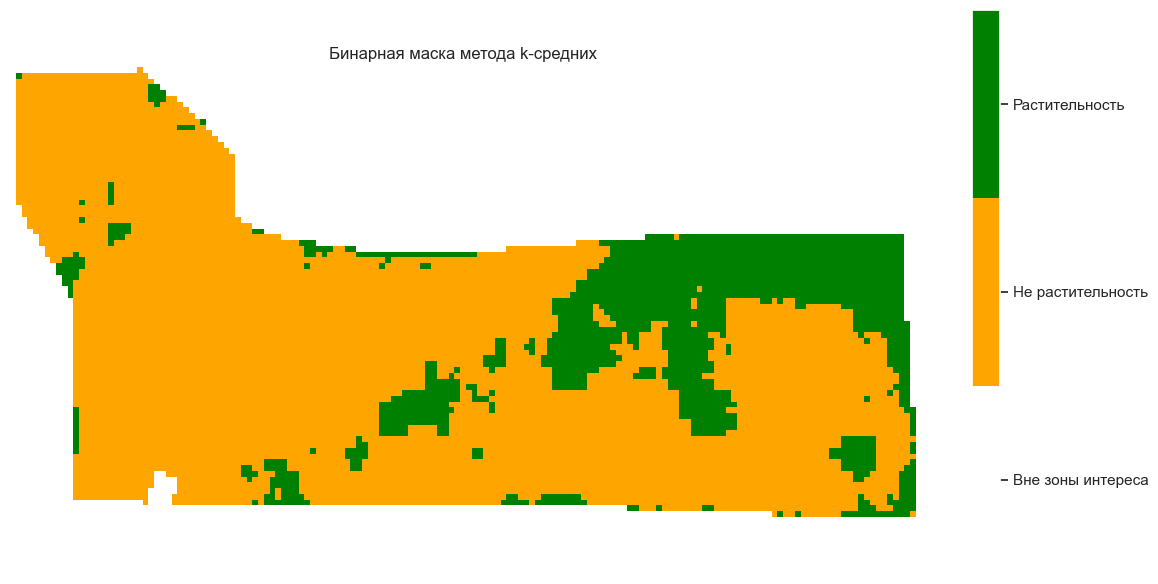

In [221]:
test_index = eval(input_text)

test_thresh = test_index.min() 
#     test_thresh = (test_index.max() + test_index.min())/2

test_filter = test_index >= test_thresh; test_mask = ~test_filter
test_meet = ma.masked_array(test_index, mask=test_mask)

#     lower_bound = 0;  upper_bound = 1
lower_bound = test_meet.min(); upper_bound = test_meet.max()


current_median = ma.median(test_meet)
coefficient = desired_median / current_median
test_meet = test_meet * coefficient


# Unmask and extract valid (unmasked) values
valid_data = test_meet.compressed()  # Extract valid (unmasked) elements
print(valid_data.dtype)

# Step 2: Apply K-means clustering with 2 clusters
kmeans = KMeans(n_clusters=2, random_state=42)
cluster_labels = kmeans.fit_predict(valid_data.reshape(-1, 1))

# Step 3: Create binary mask for clustering
binary_mask = np.full(test_meet.shape, -1, dtype=int)  # Initialize with -1 for masked positions
binary_mask[~test_meet.mask] = cluster_labels  # Assign cluster labels to unmasked positions

# Define a custom colormap: white for -1, orange for 0s, green for 1s
custom_cmap = ListedColormap(["white", "orange", "green"])

# Create a mapping for the colorbar to align -1, 0, and 1
bounds = [-1.5, -0.5, 0.5, 1.5]  # Define boundaries for each color
norma = plt.matplotlib.colors.BoundaryNorm(bounds, custom_cmap.N)

plt.figure(figsize=(12, 6))  # Adjust width and height as needed

# Plot with the custom colormap and norm
plt.imshow(binary_mask, cmap=custom_cmap, norm=norma, interpolation="nearest")
cbar = plt.colorbar(ticks=[-1, 0, 1])  # Add ticks for -1, 0, 1
cbar.ax.set_yticklabels(['Вне зоны интереса', 'Не растительность', 'Растительность'])  # Label ticks
plt.title("Бинарная маска метода k-средних")
plt.axis('off')
plt.tight_layout()
plt.show()

In [222]:
mask = binary_mask == -1
binary_mask = ma.masked_array(binary_mask, mask=mask)

mask = binary_mask == 0
binary_mask = ma.masked_array(binary_mask, mask=mask)

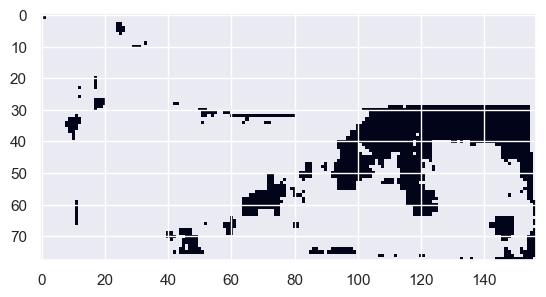

In [223]:
# Plot the matrix using imshow() with default parameters
plt.imshow(binary_mask)
plt.show()

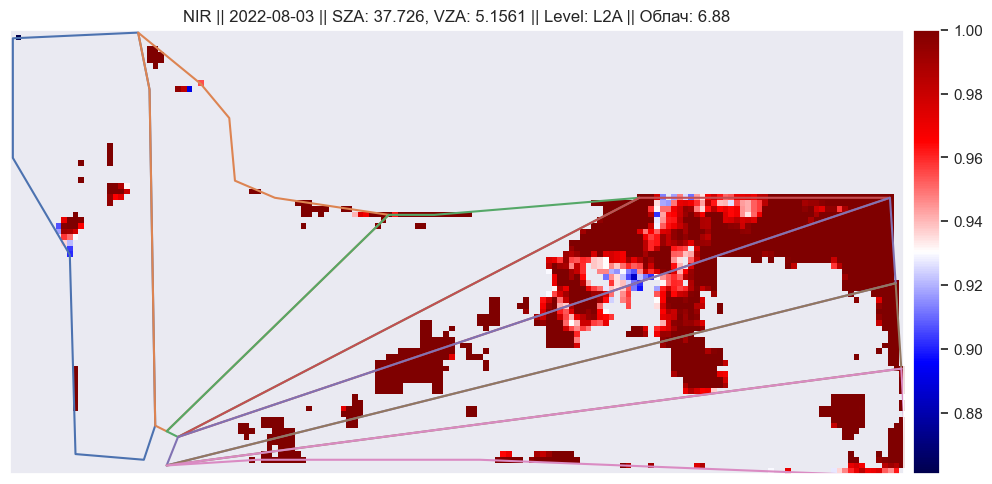

Загон,Сумма,Cреднаяя,Медианная,Станд. откл.,Коэф. асимм.,Межкв. размах,Велич. эксц.,Макс,Мин,Площадь (га),Ресурс (т/га)
№1,46.894400,0.977000,0.998600,0.034800,-1.533100,0.034600,1.405100,1.000000,0.860900,0.480000,1.536100
№2,35.704500,0.991800,1.000000,0.021900,-3.270600,0.000000,10.948000,1.000000,0.890300,0.360000,1.548400
№3,30.961300,0.998800,1.000000,0.006700,-5.290600,0.000000,26.005000,1.000000,0.962100,0.310000,1.548400
№4,587.055900,0.983300,1.000000,0.024300,-1.421400,0.029200,1.113500,1.000000,0.884800,5.970000,1.548400
№5,552.806800,0.992500,1.000000,0.017000,-2.584000,0.000800,6.654500,1.000000,0.897900,5.570000,1.548400
№6,156.566600,0.997200,1.000000,0.008500,-3.963300,0.000000,18.455500,1.000000,0.937100,1.570000,1.548400
№7,142.067900,0.993500,1.000000,0.014800,-2.610100,0.000000,6.582200,1.000000,0.927300,1.430000,1.548400
Пастбище,1552.057400,0.989100,1.000000,0.020900,-2.180400,0.011700,4.558600,1.000000,0.860900,15.690000,10.826500


In [229]:
input_text = "NIR"
#     input_text = "SWIR3"

test_index = eval(input_text)

test_thresh = test_index.min() 
#     test_thresh = (test_index.max() + test_index.min())/2

test_filter = test_index >= test_thresh; test_mask = ~test_filter
test_meet = ma.masked_array(test_index, mask=test_mask)
test_meet = ma.masked_array(test_meet, mask=binary_mask.mask)

#     lower_bound = 0;  upper_bound = 1
lower_bound = test_meet.min(); upper_bound = test_meet.max()


# current_median = ma.median(test_meet)
# coefficient = desired_median / current_median
# test_meet = test_meet * coefficient    


#     show_real_pasture()
show_pasture_index(test_meet, lower_bound, upper_bound, show_hists=False, save_excel=False, show_index=True, show_table=True)  

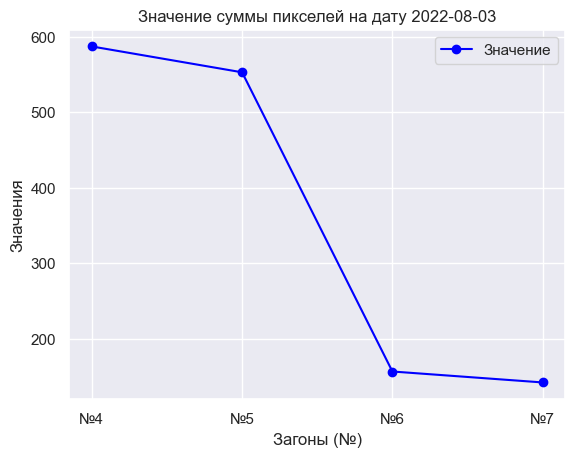

In [262]:
x = ["№4", "№5", "№6", "№7"]
y = [
587.05,
552.80,
156.56,
142.06
]

correlation_dict = dict()

# Plot with markers
plt.plot(x, y, marker='o', color='blue', label='Значение')

# Customize axes and title
plt.xlabel('Загоны (№)')
plt.ylabel('Значения')
plt.title(f'Значение суммы пикселей на дату {start_date}')

# Add a legend
plt.legend()

# Show the plot
plt.show()

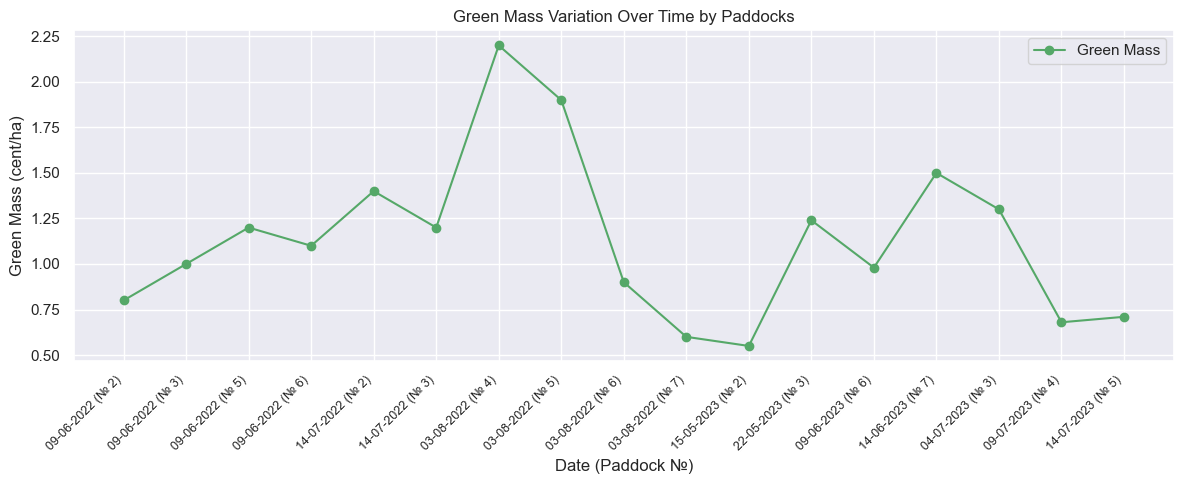

In [102]:
import matplotlib.pyplot as plt
import datetime

# Provided data
time = ["6/9/2022", "6/9/2022", "6/9/2022", "6/9/2022", "7/14/2022", "7/14/2022", 
        "8/3/2022", "8/3/2022", "8/3/2022", "8/3/2022", "5/15/2023", "5/22/2023", 
        "6/9/2023", "6/14/2023", "7/4/2023", "7/9/2023", "7/14/2023"]

greenmass = [0.8, 1, 1.2, 1.1, 1.4, 1.2, 2.2, 1.9, 0.9, 0.6, 0.55, 1.24, 
             0.98, 1.5, 1.3, 0.68, 0.71]

zagon = [2, 3, 5, 6, 2, 3, 4, 5, 6, 7, 2, 3, 6, 7, 3, 4, 5]

# Convert date strings to datetime objects for sorting
dates = [datetime.datetime.strptime(d, "%m/%d/%Y") for d in time]

# Format x-axis labels as "dd-mm-yyyy (№ zagon)"
x_labels = [d.strftime("%d-%m-%Y") + f" (№ {z})" for d, z in zip(dates, zagon)]

# Sort data by date for proper plotting
sorted_data = sorted(zip(dates, x_labels, greenmass), key=lambda x: x[0])
sorted_dates, sorted_labels, sorted_greenmass = zip(*sorted_data)

# Create the plot
plt.figure(figsize=(12, 5))
plt.plot(sorted_labels, sorted_greenmass, marker='o', linestyle='-', color='g', label="Green Mass")

# Formatting
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.ylabel("Green Mass (cent/ha)")
plt.xlabel("Date (Paddock №)")
plt.title("Green Mass Variation Over Time by Paddocks")
plt.grid(True)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()
